# Diffusion models 

MNIST data

2024-2-10

Author: Yung-Kyun Noh, Ph.D.

Hanyang University / Korea Institute for Advanced Study

2024 Machine Learning Algorithms

This notebook implements simple diffusion models using MNIST set. 

The codes are based on the functions modified from the following example, 

https://colab.research.google.com/drive/1AZ2_BAwXrU8InE_qAE9cFZ0lsIO5a_xp?usp=sharing,

which has been explained in 

https://medium.com/mlearning-ai/enerating-images-with-ddpms-a-pytorch-implementation-cef5a2ba8cb1.

The implementation of the second UNet is from the hands-on codes used in the following NVIDIA DLI program:

https://www.nvidia.com/en-us/training/instructor-led-workshops/generative-ai-with-diffusion-models/.


In [1]:
# Import of libraries
import random
import imageio
import numpy as np
from argparse import ArgumentParser

from tqdm.auto import tqdm
import matplotlib.pyplot as plt

import einops
from einops.layers.torch import Rearrange
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import DataLoader
import torch.nn.functional as F

from torchvision.transforms import Compose, ToTensor, Lambda
from torchvision.datasets.mnist import MNIST, FashionMNIST
import torchvision.transforms as transforms
import torchvision

# Setting reproducibility
SEED = 0
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)


In [2]:
!nvidia-smi

Tue Feb 13 20:06:18 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.98                 Driver Version: 535.98       CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA TITAN RTX               Off | 00000000:01:00.0 Off |                  N/A |
| 41%   46C    P8               4W / 280W |    356MiB / 24576MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [3]:
n_epochs = 20
lr = 0.001

In [4]:
def show_images(images, title=""):
    """Shows the provided images as sub-pictures in a square"""

    # Converting images to CPU numpy arrays
    if type(images) is torch.Tensor:
        images = images.detach().cpu().numpy()

    # Defining number of rows and columns
    fig = plt.figure(figsize=(8, 8))
    rows = int(len(images) ** (1 / 2))
    cols = round(len(images) / rows)

    print('Number of images:', len(images))
    # Populating figure with sub-plots
    idx = 0
    for r in range(rows):
        for c in range(cols):
            if idx < len(images):
                fig.add_subplot(rows, cols, idx + 1)
                plt.imshow(images[idx][0], cmap="gray")
                idx += 1
    fig.suptitle(title, fontsize=30)

    # Showing the figure
    plt.show()

In [5]:
def show_first_batch(loader):
    for batch in loader:
        show_images(batch[0], "Images in the first batch")
        break

### Load data

In [6]:
img_size = 28
batch_size = 128

data_transforms = [
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),  # Scales data into [0,1]
]

data_transform = transforms.Compose(data_transforms)
train_set = torchvision.datasets.MNIST(
    "./data/",
    download=True,
    train=True,
    transform=data_transform,
    )
test_set = torchvision.datasets.MNIST(
    "./data/",
    download=True,
    train=False,
    transform=data_transform,
    )
data = torch.utils.data.ConcatDataset([train_set, test_set])
dataloader = DataLoader(data, batch_size=batch_size, shuffle=True, drop_last=True)


Number of images: 128


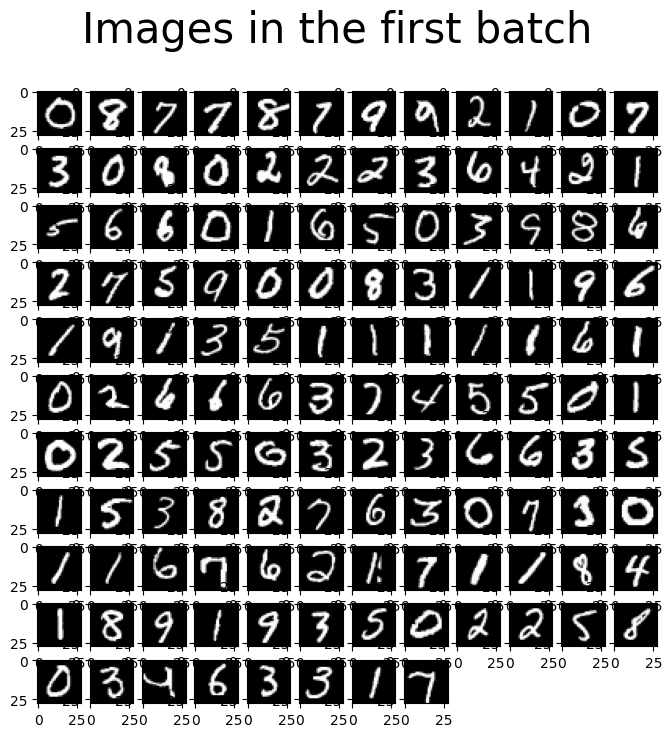

In [7]:
# Optionally, show a batch of regular images
show_first_batch(dataloader)

In [8]:
# Getting device
run_gpu = 1    # 0,1,2,3,...
dev = 'cuda:' + str(run_gpu)
# dev='cpu'

print(torch.cuda.is_available())
device = torch.device(dev if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}\t" + (f"{torch.cuda.get_device_name(0)}" if torch.cuda.is_available() else "CPU"))

True
Using device: cuda:1	NVIDIA TITAN RTX


# DDPM module


Backbone DDPM module based on the codes in

https://colab.research.google.com/drive/1AZ2_BAwXrU8InE_qAE9cFZ0lsIO5a_xp?usp=sharing,


- `n_steps`: number of diffusion steps $T$;
- `min_beta`: value of the first $\beta_t$ ($\beta_1$);
- `max_beta`: value of the last  $\beta_t$ ($\beta_T$);
- `device`: device onto which the model is run;


In [9]:
# DDPM class
class MyDDPM(nn.Module):
    def __init__(self, network, n_steps=200, min_beta=10 ** -4, max_beta=0.02, device=None):
        super(MyDDPM, self).__init__()
        self.n_steps = n_steps
        self.device = device
        self.network = network.to(device)
        self.betas = torch.linspace(min_beta, max_beta, n_steps).to(
            device)  # Number of steps is typically in the order of thousands
        self.alphas = 1 - self.betas
        self.alpha_bars = torch.tensor([torch.prod(self.alphas[:i + 1]) for i in range(len(self.alphas))]).to(device)

    def forward(self, x0, t, eta=None):
        # Make input image more noisy (we can directly skip to the desired step)
        n, c, h, w = x0.shape
        a_bar = self.alpha_bars[t]

        if eta is None:
            eta = torch.randn(n, c, h, w).to(self.device)

        noisy = a_bar.sqrt().reshape(n, 1, 1, 1) * x0 + (1 - a_bar).sqrt().reshape(n, 1, 1, 1) * eta
        return noisy

    def backward(self, x, t):
        # Run each image through the network for each timestep t in the vector t.
        # The network returns its estimation of the noise that was added.
        return self.network(x, t)
    
    def backward_cfg(self, x, t, c, c_mask):   # Classifier-free guidance
        return self.network(x, t, c, c_mask)

## Visualizing forward and backward

Among the two options in the paper, (https://arxiv.org/pdf/2006.11239.pdf) by Ho et. al., 

- $\sigma_t^2$ = $\beta_t$
- $\sigma_t^2$ = $\frac{1 - \bar{\alpha_{t-1}}}{1 - \bar{\alpha_{t}}} \beta_t$,

The first option $\sigma_t^2$ = $\beta_t$ is chosen in this implementation.


In [10]:
def show_forward(ddpm, loader, device):
    # Showing the forward process
    for batch in loader:
        imgs = batch[0]

        show_images(imgs, "Original images")

        for percent in [0.25, 0.5, 0.75, 1]:
            show_images(
                ddpm(imgs.to(device),
                     [int(percent * ddpm.n_steps) - 1 for _ in range(len(imgs))]),
                f"DDPM Noisy images {int(percent * 100)}%"
            )
        break

In [11]:
def generate_new_images(ddpm, n_samples=16, device=None, frames_per_gif=100, gif_name="sampling.gif", c=1, h=28, w=28):
    """Given a DDPM model, a number of samples to be generated and a device, returns some newly generated samples"""
    frame_idxs = np.linspace(0, ddpm.n_steps, frames_per_gif).astype(np.uint)
    frames = []

    with torch.no_grad():
        if device is None:
            device = ddpm.device

        # Starting from random noise
        x = torch.randn(n_samples, c, h, w).to(device)

        for idx, t in enumerate(list(range(ddpm.n_steps))[::-1]):
            # Estimating noise to be removed
            time_tensor = (torch.ones(n_samples, 1) * t).to(device).long()
            eta_theta = ddpm.backward(x, time_tensor)

            alpha_t = ddpm.alphas[t]
            alpha_t_bar = ddpm.alpha_bars[t]

            # Partially denoising the image
            x = (1 / alpha_t.sqrt()) * (x - (1 - alpha_t) / (1 - alpha_t_bar).sqrt() * eta_theta)

            if t > 0:
                z = torch.randn(n_samples, c, h, w).to(device)

                # Option 1: sigma_t squared = beta_t
                beta_t = ddpm.betas[t]
                sigma_t = beta_t.sqrt()

                # Option 2: sigma_t squared = beta_tilda_t
                # prev_alpha_t_bar = ddpm.alpha_bars[t-1] if t > 0 else ddpm.alphas[0]
                # beta_tilda_t = ((1 - prev_alpha_t_bar)/(1 - alpha_t_bar)) * beta_t
                # sigma_t = beta_tilda_t.sqrt()

                # Adding some more noise like in Langevin Dynamics fashion
                x = x + sigma_t * z

            # Adding frames to the GIF
            if idx in frame_idxs or t == 0:
                # Putting digits in range [0, 255]
                normalized = x.clone()
                for i in range(len(normalized)):
                    normalized[i] -= torch.min(normalized[i])
                    normalized[i] *= 255 / torch.max(normalized[i])

                # Reshaping batch (n, c, h, w) to be a (as much as it gets) square frame
                frame = einops.rearrange(normalized, "(b1 b2) c h w -> (b1 h) (b2 w) c", b1=int(n_samples ** 0.5))
                frame = frame.cpu().numpy().astype(np.uint8)

                # Rendering frame
                frames.append(frame)

    # Storing the gif
    with imageio.get_writer(gif_name, mode="I") as writer:
        for idx, frame in enumerate(frames):
            rgb_frame = np.repeat(frame, 3, axis=2)
            writer.append_data(rgb_frame)

            # Showing the last frame for a longer time
            if idx == len(frames) - 1:
                last_rgb_frame = np.repeat(frames[-1], 3, axis=2)
                for _ in range(frames_per_gif // 3):
                    writer.append_data(last_rgb_frame)
    return x

# UNet architecture

A vanilla UNet structure was implemented from

https://colab.research.google.com/drive/1AZ2_BAwXrU8InE_qAE9cFZ0lsIO5a_xp?usp=sharing,

For 28x28 images.

In [12]:
class MyUNet(nn.Module):
    def __init__(self, n_steps=1000, time_emb_dim=100):
        super(MyUNet, self).__init__()

        # Sinusoidal embedding
        self.time_embed = nn.Embedding(n_steps, time_emb_dim)
        self.time_embed.weight.data = sinusoidal_embedding(n_steps, time_emb_dim)
        self.time_embed.requires_grad_(False)

        # First half
        self.te1 = self._make_te(time_emb_dim, 1)
        self.b1 = nn.Sequential(
            MyBlock((1, 28, 28), 1, 10),
            MyBlock((10, 28, 28), 10, 10),
            MyBlock((10, 28, 28), 10, 10)
        )
        self.down1 = nn.Conv2d(10, 10, 4, 2, 1)

        self.te2 = self._make_te(time_emb_dim, 10)
        self.b2 = nn.Sequential(
            MyBlock((10, 14, 14), 10, 20),
            MyBlock((20, 14, 14), 20, 20),
            MyBlock((20, 14, 14), 20, 20)
        )
        self.down2 = nn.Conv2d(20, 20, 4, 2, 1)

        self.te3 = self._make_te(time_emb_dim, 20)
        self.b3 = nn.Sequential(
            MyBlock((20, 7, 7), 20, 40),
            MyBlock((40, 7, 7), 40, 40),
            MyBlock((40, 7, 7), 40, 40)
        )
        self.down3 = nn.Sequential(
            nn.Conv2d(40, 40, 2, 1),
            nn.SiLU(),
            nn.Conv2d(40, 40, 4, 2, 1)
        )

        # Bottleneck
        self.te_mid = self._make_te(time_emb_dim, 40)
        self.b_mid = nn.Sequential(
            MyBlock((40, 3, 3), 40, 20),
            MyBlock((20, 3, 3), 20, 20),
            MyBlock((20, 3, 3), 20, 40)
        )

        # Second half
        self.up1 = nn.Sequential(
            nn.ConvTranspose2d(40, 40, 4, 2, 1),
            nn.SiLU(),
            nn.ConvTranspose2d(40, 40, 2, 1)
        )

        self.te4 = self._make_te(time_emb_dim, 80)
        self.b4 = nn.Sequential(
            MyBlock((80, 7, 7), 80, 40),
            MyBlock((40, 7, 7), 40, 20),
            MyBlock((20, 7, 7), 20, 20)
        )

        self.up2 = nn.ConvTranspose2d(20, 20, 4, 2, 1)
        self.te5 = self._make_te(time_emb_dim, 40)
        self.b5 = nn.Sequential(
            MyBlock((40, 14, 14), 40, 20),
            MyBlock((20, 14, 14), 20, 10),
            MyBlock((10, 14, 14), 10, 10)
        )

        self.up3 = nn.ConvTranspose2d(10, 10, 4, 2, 1)
        self.te_out = self._make_te(time_emb_dim, 20)
        self.b_out = nn.Sequential(
            MyBlock((20, 28, 28), 20, 10),
            MyBlock((10, 28, 28), 10, 10),
            MyBlock((10, 28, 28), 10, 10, normalize=False)
        )

        self.conv_out = nn.Conv2d(10, 1, 3, 1, 1)

    def forward(self, x, t):
        # x is (N, 2, 28, 28) (image with positional embedding stacked on channel dimension)
        t = self.time_embed(t)
        n = len(x)
        out1 = self.b1(x + self.te1(t).reshape(n, -1, 1, 1))  # (N, 10, 28, 28)
        out2 = self.b2(self.down1(out1) + self.te2(t).reshape(n, -1, 1, 1))  # (N, 20, 14, 14)
        out3 = self.b3(self.down2(out2) + self.te3(t).reshape(n, -1, 1, 1))  # (N, 40, 7, 7)

        out_mid = self.b_mid(self.down3(out3) + self.te_mid(t).reshape(n, -1, 1, 1))  # (N, 40, 3, 3)

        out4 = torch.cat((out3, self.up1(out_mid)), dim=1)  # (N, 80, 7, 7)
        out4 = self.b4(out4 + self.te4(t).reshape(n, -1, 1, 1))  # (N, 20, 7, 7)

        out5 = torch.cat((out2, self.up2(out4)), dim=1)  # (N, 40, 14, 14)
        out5 = self.b5(out5 + self.te5(t).reshape(n, -1, 1, 1))  # (N, 10, 14, 14)

        out = torch.cat((out1, self.up3(out5)), dim=1)  # (N, 20, 28, 28)
        out = self.b_out(out + self.te_out(t).reshape(n, -1, 1, 1))  # (N, 1, 28, 28)

        out = self.conv_out(out)

        return out

    def _make_te(self, dim_in, dim_out):
        return nn.Sequential(
            nn.Linear(dim_in, dim_out),
            nn.SiLU(),
            nn.Linear(dim_out, dim_out)
        )

In [13]:
class MyBlock(nn.Module):
    def __init__(self, shape, in_c, out_c, kernel_size=3, stride=1, padding=1, activation=None, normalize=True):
        super(MyBlock, self).__init__()
        self.ln = nn.LayerNorm(shape)
        self.conv1 = nn.Conv2d(in_c, out_c, kernel_size, stride, padding)
        self.conv2 = nn.Conv2d(out_c, out_c, kernel_size, stride, padding)
        self.activation = nn.SiLU() if activation is None else activation
        self.normalize = normalize

    def forward(self, x):
        out = self.ln(x) if self.normalize else x
        out = self.conv1(out)
        out = self.activation(out)
        out = self.conv2(out)
        out = self.activation(out)
        return out

In [14]:
def sinusoidal_embedding(n, d):
    # Returns the standard positional embedding
    embedding = torch.zeros(n, d)
    wk = torch.tensor([1 / 10_000 ** (2 * j / d) for j in range(d)])
    wk = wk.reshape((1, d))
    t = torch.arange(n).reshape((n, 1))
    embedding[:,::2] = torch.sin(t * wk[:,::2])
    embedding[:,1::2] = torch.cos(t * wk[:,::2])

    return embedding

# Initiating the model


In [15]:
# Defining model
n_steps, min_beta, max_beta = 1000, 10 ** -4, 0.02  # Originally used by the authors
ddpm = MyDDPM(MyUNet(n_steps), n_steps=n_steps, min_beta=min_beta, max_beta=max_beta, device=device)


In [16]:
sum([p.numel() for p in ddpm.parameters()])

606852

# Optional visualizations

Optionally, you can load a pre-trained model that will be further trained using

ddpm.load_state_dict(torch.load(store_path, map_location=device))

Number of images: 128


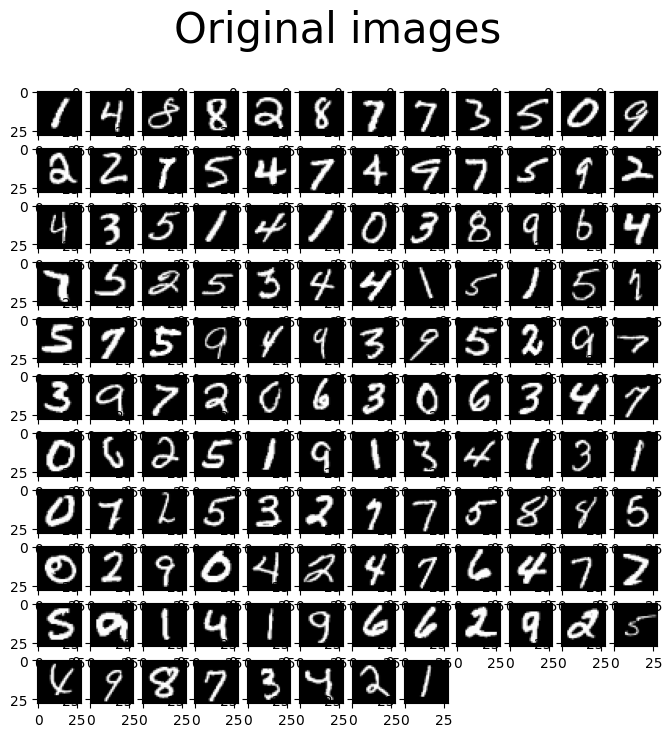

Number of images: 128


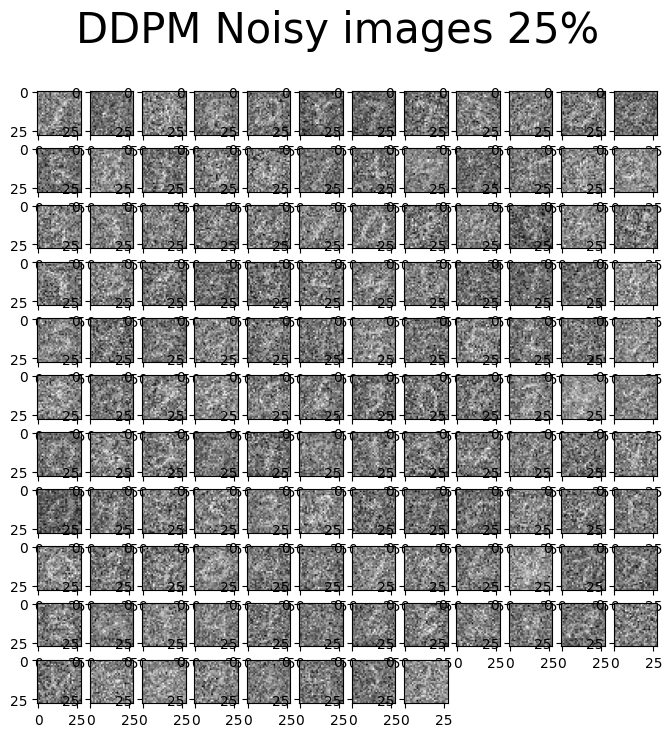

Number of images: 128


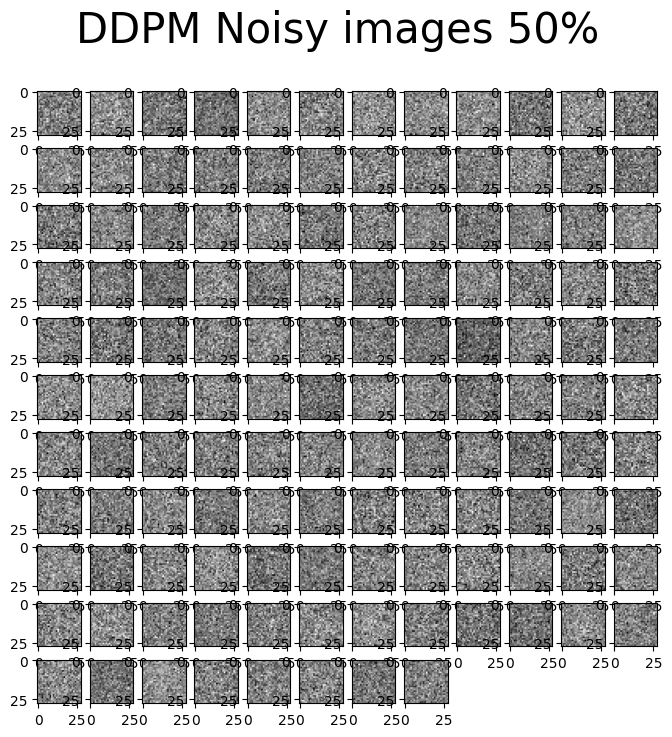

Number of images: 128


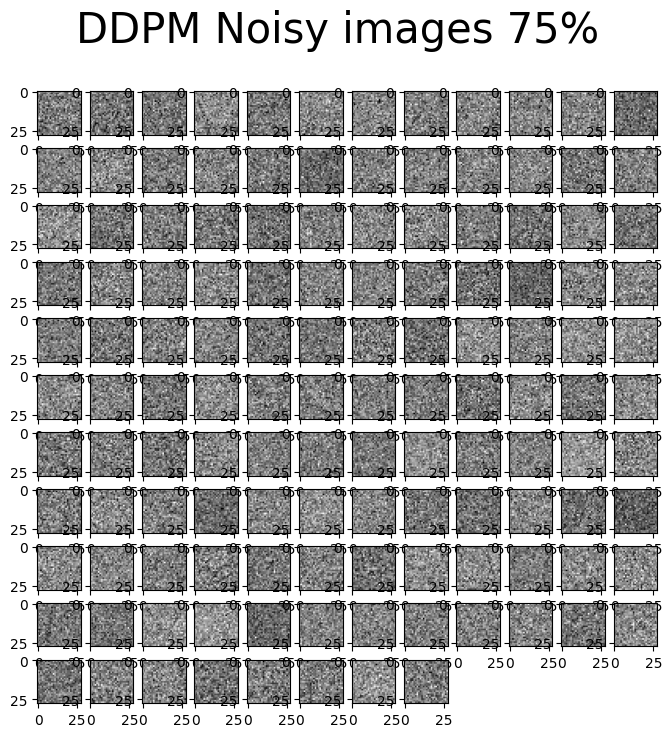

Number of images: 128


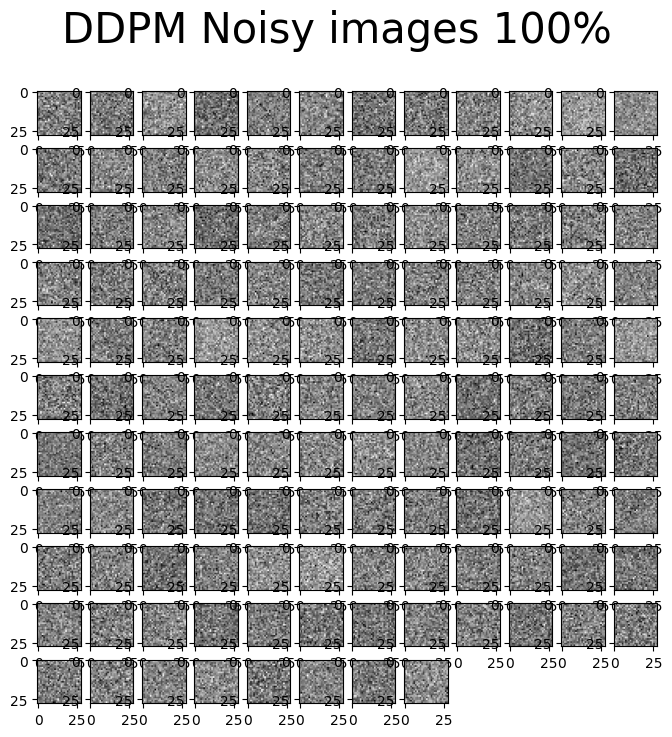

In [17]:
# Optionally, show the diffusion (forward) process
show_forward(ddpm, dataloader, device)

### Optionally, show the denoising (backward) process without 

Number of images: 16


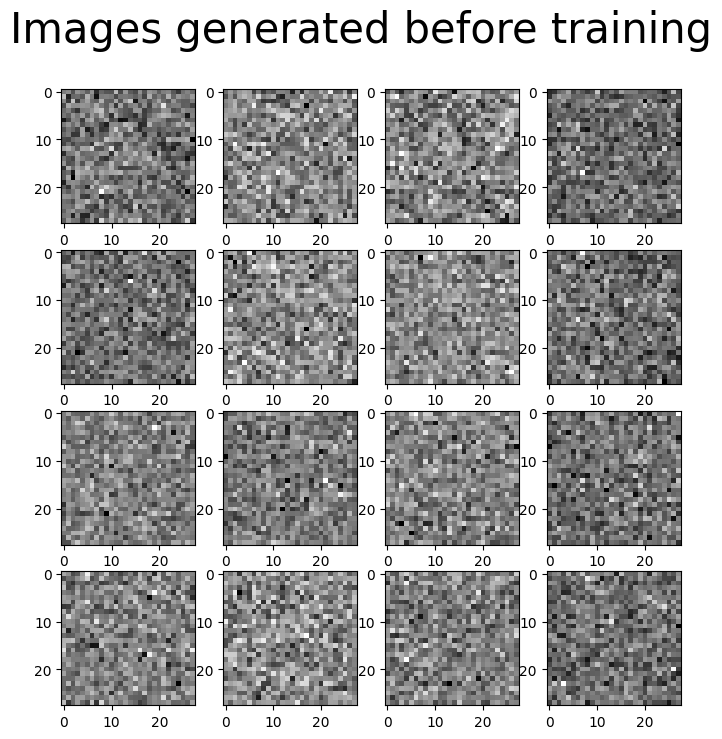

In [18]:
generated = generate_new_images(ddpm, gif_name="before_training.gif")
show_images(generated, "Images generated before training")

# Training


In [19]:
def training_loop(ddpm, loader, n_epochs, optim, device, display=False, store_path="ddpm_model.pt"):
    mse = nn.MSELoss()
    best_loss = float("inf")
    n_steps = ddpm.n_steps

    for epoch in tqdm(range(n_epochs), desc=f"Training progress", colour="#00ff00"):
        epoch_loss = 0.0
        for step, batch in enumerate(tqdm(loader, leave=False, desc=f"Epoch {epoch + 1}/{n_epochs}", colour="#005500")):
            # Loading data
            x0 = batch[0].to(device)
            n = len(x0)

            # Picking some noise for each of the images in the batch, a timestep and the respective alpha_bars
            eta = torch.randn_like(x0).to(device)
            t = torch.randint(0, n_steps, (n,)).to(device)

            # Computing the noisy image based on x0 and the time-step (forward process)
            noisy_imgs = ddpm(x0, t, eta)

            # Getting model estimation of noise based on the images and the time-step
            eta_theta = ddpm.backward(noisy_imgs, t.reshape(n, -1))

            # Optimizing the MSE between the noise plugged and the predicted noise
            loss = mse(eta_theta, eta)
            optim.zero_grad()
            loss.backward()
            optim.step()

            epoch_loss += loss.item() * len(x0) / len(loader.dataset)

        # Display images generated at this epoch
        if display:
            show_images(generate_new_images(ddpm, device=device), f"Images generated at epoch {epoch + 1}")

        log_string = f"Loss at epoch {epoch + 1}: {epoch_loss:.3f}"

        # Storing the model
        if best_loss > epoch_loss:
            best_loss = epoch_loss
            torch.save(ddpm.state_dict(), store_path)
            log_string += " --> Best model ever (stored)"

        print(log_string)

In [20]:
# Training
store_path = "ddpm_mnist.pt"
training_loop(ddpm, dataloader, n_epochs, optim=Adam(ddpm.parameters(), lr), device=device, store_path=store_path)

Training progress:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1/20:   0%|          | 0/546 [00:00<?, ?it/s]

Loss at epoch 1: 0.131 --> Best model ever (stored)


Epoch 2/20:   0%|          | 0/546 [00:00<?, ?it/s]

Loss at epoch 2: 0.032 --> Best model ever (stored)


Epoch 3/20:   0%|          | 0/546 [00:00<?, ?it/s]

Loss at epoch 3: 0.029 --> Best model ever (stored)


Epoch 4/20:   0%|          | 0/546 [00:00<?, ?it/s]

Loss at epoch 4: 0.027 --> Best model ever (stored)


Epoch 5/20:   0%|          | 0/546 [00:00<?, ?it/s]

Loss at epoch 5: 0.025 --> Best model ever (stored)


Epoch 6/20:   0%|          | 0/546 [00:00<?, ?it/s]

Loss at epoch 6: 0.024 --> Best model ever (stored)


Epoch 7/20:   0%|          | 0/546 [00:00<?, ?it/s]

Loss at epoch 7: 0.024 --> Best model ever (stored)


Epoch 8/20:   0%|          | 0/546 [00:00<?, ?it/s]

Loss at epoch 8: 0.023 --> Best model ever (stored)


Epoch 9/20:   0%|          | 0/546 [00:00<?, ?it/s]

Loss at epoch 9: 0.023 --> Best model ever (stored)


Epoch 10/20:   0%|          | 0/546 [00:00<?, ?it/s]

Loss at epoch 10: 0.022 --> Best model ever (stored)


Epoch 11/20:   0%|          | 0/546 [00:00<?, ?it/s]

Loss at epoch 11: 0.022 --> Best model ever (stored)


Epoch 12/20:   0%|          | 0/546 [00:00<?, ?it/s]

Loss at epoch 12: 0.022


Epoch 13/20:   0%|          | 0/546 [00:00<?, ?it/s]

Loss at epoch 13: 0.022


Epoch 14/20:   0%|          | 0/546 [00:00<?, ?it/s]

Loss at epoch 14: 0.021 --> Best model ever (stored)


Epoch 15/20:   0%|          | 0/546 [00:00<?, ?it/s]

Loss at epoch 15: 0.021


Epoch 16/20:   0%|          | 0/546 [00:00<?, ?it/s]

Loss at epoch 16: 0.021 --> Best model ever (stored)


Epoch 17/20:   0%|          | 0/546 [00:00<?, ?it/s]

Loss at epoch 17: 0.021


Epoch 18/20:   0%|          | 0/546 [00:00<?, ?it/s]

Loss at epoch 18: 0.020 --> Best model ever (stored)


Epoch 19/20:   0%|          | 0/546 [00:00<?, ?it/s]

Loss at epoch 19: 0.020


Epoch 20/20:   0%|          | 0/546 [00:00<?, ?it/s]

Loss at epoch 20: 0.020


# Testing the trained model


In [21]:
# Loading the trained model
best_model = MyDDPM(MyUNet(), n_steps=n_steps, device=device)
store_path = "ddpm_mnist.pt"
best_model.load_state_dict(torch.load(store_path, map_location=device))
best_model.eval()
print("Model loaded")

Model loaded


Generating new images
Number of images: 100


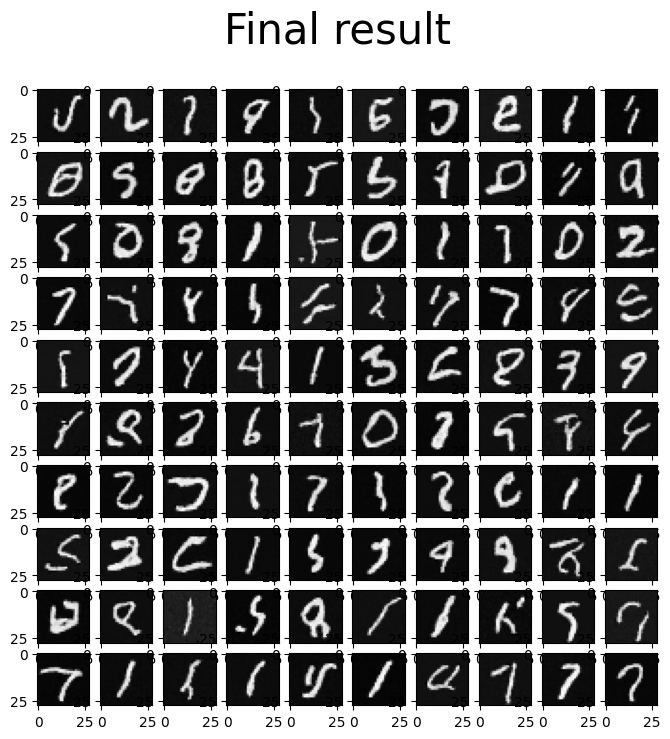

In [22]:
print("Generating new images")
generated = generate_new_images(
        best_model,
        n_samples=100,
        device=device,
        gif_name="mnist.gif"
    )
show_images(generated, "Final result")

# Visualizing the diffusion

In [ ]:
from IPython.display import Image

Image(open('mnist.gif','rb').read())

# Use upgraded UNet structure

Advanced techniques such as Group normalization and GeLU have been implemented. The new structure is based on the NVIDIA DLI hands on implementation of the UNet.

In [ ]:
import math

In [ ]:
class MyUNet2(nn.Module):
    def __init__(self, n_steps=1000, time_emb_dim=8):
        super(MyUNet2, self).__init__()

        img_size = 28
        img_ch = 1
        self.T = n_steps
        down_chs=(64, 64, 128)
        up_chs = down_chs[::-1]  # Reverse of the down channels
        latent_image_size = img_size // 4  # 2 ** (len(down_chs) - 1)
        t_embed_dim = time_emb_dim
        small_group_size = 8
        big_group_size = 32

        # Inital convolution
        self.down0 = ResidualConvBlock(img_ch, down_chs[0], small_group_size)

        # Downsample
        self.down1 = DownBlock(down_chs[0], down_chs[1], big_group_size)
        self.down2 = DownBlock(down_chs[1], down_chs[2], big_group_size)
        self.to_vec = nn.Sequential(nn.Flatten(), nn.GELU())

        # Embeddings
        self.dense_emb = nn.Sequential(
            nn.Linear(down_chs[2] * latent_image_size**2, down_chs[1]),
            nn.ReLU(),
            nn.Linear(down_chs[1], down_chs[1]),
            nn.ReLU(),
            nn.Linear(down_chs[1], down_chs[2] * latent_image_size**2),
            nn.ReLU(),
        )
        self.sinusoidaltime = SinusoidalPositionEmbedBlock(t_embed_dim)
        self.t_emb1 = EmbedBlock(t_embed_dim, up_chs[0])
        self.t_emb2 = EmbedBlock(t_embed_dim, up_chs[1])

        # Upsample
        self.up0 = nn.Sequential(
            nn.Unflatten(1, (up_chs[0], latent_image_size, latent_image_size)),
            GELUConvBlock(up_chs[0], up_chs[0], big_group_size),
        )
        self.up1 = UpBlock(up_chs[0], up_chs[1], big_group_size)
        self.up2 = UpBlock(up_chs[1], up_chs[2], big_group_size)

        # Match output channels and one last concatenation
        self.out = nn.Sequential(
            nn.Conv2d(2 * up_chs[-1], up_chs[-1], 3, 1, 1),
            nn.GroupNorm(small_group_size, up_chs[-1]),
            nn.ReLU(),
            nn.Conv2d(up_chs[-1], img_ch, 3, 1, 1),
        )


    def forward(self, x, t):
        down0 = self.down0(x)
        down1 = self.down1(down0)
        down2 = self.down2(down1)
        latent_vec = self.to_vec(down2)

        latent_vec = self.dense_emb(latent_vec)
        t = t.float() / self.T  # Convert from [0, T] to [0, 1]
        t = self.sinusoidaltime(t)
        t_emb1 = self.t_emb1(t)
        t_emb2 = self.t_emb2(t)

        up0 = self.up0(latent_vec)
        up1 = self.up1(up0 + t_emb1, down2)
        up2 = self.up2(up1 + t_emb2, down1)

        return self.out(torch.cat((up2, down0), 1))


In [ ]:
class ResidualConvBlock(nn.Module):
    def __init__(self, in_chs, out_chs, group_size):
        super().__init__()
        self.conv1 = GELUConvBlock(in_chs, out_chs, group_size)
        self.conv2 = GELUConvBlock(out_chs, out_chs, group_size)

    def forward(self, x):
        x1 = self.conv1(x)
        x2 = self.conv2(x1)
        out = x1 + x2
        return out

In [ ]:
class GELUConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch, group_size):
        super().__init__()
        layers = [
            nn.Conv2d(in_ch, out_ch, 3, 1, 1),
            nn.GroupNorm(group_size, out_ch),
            nn.GELU(),
        ]
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

In [ ]:
class DownBlock(nn.Module):
    def __init__(self, in_chs, out_chs, group_size):
        super(DownBlock, self).__init__()
        layers = [
            GELUConvBlock(in_chs, out_chs, group_size),
            GELUConvBlock(out_chs, out_chs, group_size),
            RearrangePoolBlock(out_chs, group_size),
        ]
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

In [ ]:
class UpBlock(nn.Module):
    def __init__(self, in_chs, out_chs, group_size):
        super(UpBlock, self).__init__()
        layers = [
            nn.ConvTranspose2d(2 * in_chs, out_chs, 2, 2),
            GELUConvBlock(out_chs, out_chs, group_size),
            GELUConvBlock(out_chs, out_chs, group_size),
            GELUConvBlock(out_chs, out_chs, group_size),
            GELUConvBlock(out_chs, out_chs, group_size),
        ]
        self.model = nn.Sequential(*layers)

    def forward(self, x, skip):
        x = torch.cat((x, skip), 1)
        x = self.model(x)
        return x

In [ ]:
class RearrangePoolBlock(nn.Module):
    def __init__(self, in_chs, group_size):
        super().__init__()
        self.rearrange = Rearrange("b c (h p1) (w p2) -> b (c p1 p2) h w", p1=2, p2=2)
        self.conv = GELUConvBlock(4 * in_chs, in_chs, group_size)

    def forward(self, x):
        x = self.rearrange(x)
        return self.conv(x)

In [ ]:
class SinusoidalPositionEmbedBlock(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings

In [ ]:
class EmbedBlock(nn.Module):
    def __init__(self, input_dim, emb_dim):
        super(EmbedBlock, self).__init__()
        self.input_dim = input_dim
        layers = [
            nn.Linear(input_dim, emb_dim),
            nn.GELU(),
            nn.Linear(emb_dim, emb_dim),
            nn.Unflatten(1, (emb_dim, 1, 1)),
        ]
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        x = x.view(-1, self.input_dim)
        return self.model(x)

# Initiating the model


Instantiation of an advanced UNet model

In [ ]:
# Defining model
n_steps, min_beta, max_beta = 1000, 10 ** -4, 0.02  # Originally used by the authors
# MyUNet2
ddpm = MyDDPM(MyUNet2(n_steps), n_steps=n_steps, min_beta=min_beta, max_beta=max_beta, device=device)

In [ ]:
sum([p.numel() for p in ddpm.parameters()])

# Training


In [35]:
# Training
store_path = "ddpm_mnist2.pt"
training_loop(ddpm, dataloader, n_epochs, optim=Adam(ddpm.parameters(), lr), device=device, store_path=store_path)

Loss at epoch 4: 0.018 --> Best model ever (stored)


Epoch 5/20:   0%|          | 0/546 [00:00<?, ?it/s]

Loss at epoch 5: 0.017 --> Best model ever (stored)


Epoch 6/20:   0%|          | 0/546 [00:00<?, ?it/s]

Loss at epoch 6: 0.017 --> Best model ever (stored)


Epoch 7/20:   0%|          | 0/546 [00:00<?, ?it/s]

Loss at epoch 7: 0.016 --> Best model ever (stored)


Epoch 8/20:   0%|          | 0/546 [00:00<?, ?it/s]

Loss at epoch 8: 0.016 --> Best model ever (stored)


Epoch 9/20:   0%|          | 0/546 [00:00<?, ?it/s]

Loss at epoch 9: 0.016 --> Best model ever (stored)


Epoch 10/20:   0%|          | 0/546 [00:00<?, ?it/s]

Loss at epoch 10: 0.015 --> Best model ever (stored)


Epoch 11/20:   0%|          | 0/546 [00:00<?, ?it/s]

Loss at epoch 11: 0.016


Epoch 12/20:   0%|          | 0/546 [00:00<?, ?it/s]

Loss at epoch 12: 0.016


Epoch 13/20:   0%|          | 0/546 [00:00<?, ?it/s]

Loss at epoch 13: 0.015 --> Best model ever (stored)


Epoch 14/20:   0%|          | 0/546 [00:00<?, ?it/s]

Loss at epoch 14: 0.015 --> Best model ever (stored)


Epoch 15/20:   0%|          | 0/546 [00:00<?, ?it/s]

Loss at epoch 15: 0.015 --> Best model ever (stored)


Epoch 16/20:   0%|          | 0/546 [00:00<?, ?it/s]

Loss at epoch 16: 0.015 --> Best model ever (stored)


Epoch 17/20:   0%|          | 0/546 [00:00<?, ?it/s]

Loss at epoch 17: 0.015 --> Best model ever (stored)


Epoch 18/20:   0%|          | 0/546 [00:00<?, ?it/s]

Loss at epoch 18: 0.015


Epoch 19/20:   0%|          | 0/546 [00:00<?, ?it/s]

Loss at epoch 19: 0.015


Epoch 20/20:   0%|          | 0/546 [00:00<?, ?it/s]

Loss at epoch 20: 0.015 --> Best model ever (stored)


# Testing the trained model


In [36]:
# Loading the trained model
best_model = MyDDPM(MyUNet2(), n_steps=n_steps, device=device)
store_path = "ddpm_mnist2.pt"
best_model.load_state_dict(torch.load(store_path, map_location=device))
best_model.eval()
print("Model loaded")

Model loaded


Generating new images
Number of images: 100


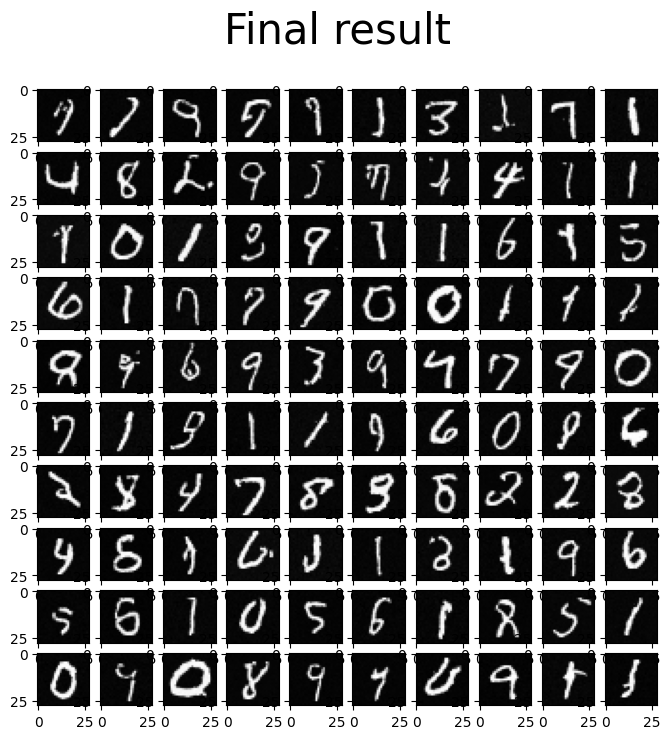

In [37]:
print("Generating new images")

generated = generate_new_images(
        best_model,
        n_samples=100,
        device=device,
        gif_name="mnist2.gif"
    )
show_images(generated, "Final result")

In [ ]:
from IPython.display import Image

Image(open('mnist2.gif','rb').read())

# Classifier-free Guidance

The classifier-free guidance model is implemented with the advanced UNet structure.

In [ ]:
class MyUNet_CFG(nn.Module):
    def __init__(self, n_steps=1000, time_emb_dim=8):
        super(MyUNet_CFG, self).__init__()

        img_size = 28
        img_ch = 1
        self.T = n_steps
        down_chs=(64, 64, 128)
        up_chs = down_chs[::-1]  # Reverse of the down channels
        latent_image_size = img_size // 4  # 2 ** (len(down_chs) - 1)
        t_embed_dim = time_emb_dim
        c_embed_dim = 10
        small_group_size = 8
        big_group_size = 32

        # Inital convolution
        self.down0 = ResidualConvBlock(img_ch, down_chs[0], small_group_size)

        # Downsample
        self.down1 = DownBlock(down_chs[0], down_chs[1], big_group_size)
        self.down2 = DownBlock(down_chs[1], down_chs[2], big_group_size)
        self.to_vec = nn.Sequential(nn.Flatten(), nn.GELU())

        # Embeddings
        self.dense_emb = nn.Sequential(
            nn.Linear(down_chs[2] * latent_image_size**2, down_chs[1]),
            nn.ReLU(),
            nn.Linear(down_chs[1], down_chs[1]),
            nn.ReLU(),
            nn.Linear(down_chs[1], down_chs[2] * latent_image_size**2),
            nn.ReLU(),
        )
        self.sinusoidaltime = SinusoidalPositionEmbedBlock(t_embed_dim)
        self.t_emb1 = EmbedBlock(t_embed_dim, up_chs[0])
        self.t_emb2 = EmbedBlock(t_embed_dim, up_chs[1])
        self.c_embed1 = EmbedBlock(c_embed_dim, up_chs[0])
        self.c_embed2 = EmbedBlock(c_embed_dim, up_chs[1])

        # Upsample
        self.up0 = nn.Sequential(
            nn.Unflatten(1, (up_chs[0], latent_image_size, latent_image_size)),
            GELUConvBlock(up_chs[0], up_chs[0], big_group_size),
        )
        self.up1 = UpBlock(up_chs[0], up_chs[1], big_group_size)
        self.up2 = UpBlock(up_chs[1], up_chs[2], big_group_size)

        # Match output channels and one last concatenation
        self.out = nn.Sequential(
            nn.Conv2d(2 * up_chs[-1], up_chs[-1], 3, 1, 1),
            nn.GroupNorm(small_group_size, up_chs[-1]),
            nn.ReLU(),
            nn.Conv2d(up_chs[-1], img_ch, 3, 1, 1),
        )

    
    def forward(self, x, t, c, c_mask):
        down0 = self.down0(x)
        down1 = self.down1(down0)
        down2 = self.down2(down1)
        latent_vec = self.to_vec(down2)

        latent_vec = self.dense_emb(latent_vec)
        t = t.float() / self.T  # Convert from [0, T] to [0, 1]
        t = self.sinusoidaltime(t)
        t_emb1 = self.t_emb1(t)
        t_emb2 = self.t_emb2(t)

        c = c * c_mask
        c_emb1 = self.c_embed1(c)
        c_emb2 = self.c_embed2(c)

        up0 = self.up0(latent_vec)
        up1 = self.up1(c_emb1 * up0 + t_emb1, down2)
        up2 = self.up2(c_emb2 * up1 + t_emb2, down1)

        return self.out(torch.cat((up2, down0), 1))


# Initiate network

In [ ]:
# Defining model
n_steps, min_beta, max_beta = 1000, 10 ** -4, 0.02  # Originally used by the authors
# MyUNet2
ddpm = MyDDPM(MyUNet_CFG(n_steps), n_steps=n_steps, min_beta=min_beta, max_beta=max_beta, device=device)

In [ ]:
sum([p.numel() for p in ddpm.parameters()])

# Training

In [ ]:
def get_context_mask(c, drop_prob, n_classes=10, device='cpu'):
    c_hot = F.one_hot(c.to(torch.int64), num_classes=n_classes).to(device)
    c_mask = torch.bernoulli(torch.ones_like(c_hot).float() - drop_prob).to(device)
    return c_hot, c_mask

In [ ]:
def training_loop_cfg(ddpm, loader, n_epochs, optim, device, n_classes=10, c_drop_prob=0.1, display=False, store_path="ddpm_model.pt"):
    mse = nn.MSELoss()
    best_loss = float("inf")
    n_steps = ddpm.n_steps

    for epoch in tqdm(range(n_epochs), desc=f"Training progress", colour="#00ff00"):
        epoch_loss = 0.0
        for step, batch in enumerate(tqdm(loader, leave=False, desc=f"Epoch {epoch + 1}/{n_epochs}", colour="#005500")):
            # Loading data
            x0 = batch[0].to(device)
            n = len(x0)
            c_hot, c_mask = get_context_mask(batch[1], c_drop_prob, n_classes=n_classes, device=device)  # New

            # Picking some noise for each of the images in the batch, a timestep and the respective alpha_bars
            eta = torch.randn_like(x0).to(device)
            t = torch.randint(0, n_steps, (n,)).to(device)

            # Computing the noisy image based on x0 and the time-step (forward process)
            noisy_imgs = ddpm(x0, t, eta)

            # Getting model estimation of noise based on the images and the time-step
            eta_theta = ddpm.backward_cfg(noisy_imgs, t.reshape(n, -1), c_hot, c_mask)

            # Optimizing the MSE between the noise plugged and the predicted noise
            loss = mse(eta_theta, eta)
            optim.zero_grad()
            loss.backward()
            optim.step()

            epoch_loss += loss.item() * len(x0) / len(loader.dataset)

        # Display images generated at this epoch
        if display:
            show_images(generate_new_images(ddpm, device=device), f"Images generated at epoch {epoch + 1}")

        log_string = f"Loss at epoch {epoch + 1}: {epoch_loss:.3f}"

        # Storing the model
        if best_loss > epoch_loss:
            best_loss = epoch_loss
            torch.save(ddpm.state_dict(), store_path)
            log_string += " --> Best model ever (stored)"

        print(log_string)

In [44]:
n_classes = 10

# Training
store_path = "ddpm_mnist_cfg.pt"
training_loop_cfg(ddpm, dataloader, n_epochs, optim=Adam(ddpm.parameters(), lr), device=device, \
                  n_classes=n_classes, store_path=store_path)

Loss at epoch 4: 0.017 --> Best model ever (stored)


Epoch 5/20:   0%|          | 0/546 [00:00<?, ?it/s]

Loss at epoch 5: 0.017 --> Best model ever (stored)


Epoch 6/20:   0%|          | 0/546 [00:00<?, ?it/s]

Loss at epoch 6: 0.016 --> Best model ever (stored)


Epoch 7/20:   0%|          | 0/546 [00:00<?, ?it/s]

Loss at epoch 7: 0.016 --> Best model ever (stored)


Epoch 8/20:   0%|          | 0/546 [00:00<?, ?it/s]

Loss at epoch 8: 0.016 --> Best model ever (stored)


Epoch 9/20:   0%|          | 0/546 [00:00<?, ?it/s]

Loss at epoch 9: 0.015 --> Best model ever (stored)


Epoch 10/20:   0%|          | 0/546 [00:00<?, ?it/s]

Loss at epoch 10: 0.015


Epoch 11/20:   0%|          | 0/546 [00:00<?, ?it/s]

Loss at epoch 11: 0.015 --> Best model ever (stored)


Epoch 12/20:   0%|          | 0/546 [00:00<?, ?it/s]

Loss at epoch 12: 0.015 --> Best model ever (stored)


Epoch 13/20:   0%|          | 0/546 [00:00<?, ?it/s]

Loss at epoch 13: 0.015 --> Best model ever (stored)


Epoch 14/20:   0%|          | 0/546 [00:00<?, ?it/s]

Loss at epoch 14: 0.015 --> Best model ever (stored)


Epoch 15/20:   0%|          | 0/546 [00:00<?, ?it/s]

Loss at epoch 15: 0.015


Epoch 16/20:   0%|          | 0/546 [00:00<?, ?it/s]

Loss at epoch 16: 0.014 --> Best model ever (stored)


Epoch 17/20:   0%|          | 0/546 [00:00<?, ?it/s]

Loss at epoch 17: 0.014 --> Best model ever (stored)


Epoch 18/20:   0%|          | 0/546 [00:00<?, ?it/s]

Loss at epoch 18: 0.014


Epoch 19/20:   0%|          | 0/546 [00:00<?, ?it/s]

Loss at epoch 19: 0.014 --> Best model ever (stored)


Epoch 20/20:   0%|          | 0/546 [00:00<?, ?it/s]

Loss at epoch 20: 0.014


In [45]:
# Loading the trained model
best_model = MyDDPM(MyUNet_CFG(), n_steps=n_steps, device=device)
store_path = "ddpm_mnist_cfg.pt"
best_model.load_state_dict(torch.load(store_path, map_location=device))
best_model.eval()
print("Model loaded")

Model loaded


In [46]:
# with w
def generate_new_images_cfg(ddpm, n_classes=10, device=None, frames_per_gif=100, gif_name="sampling.gif", \
                            c=1, h=28, w=28, w_val = 0.):
    """Given a DDPM model, a number of samples to be generated and a device, returns some newly generated samples"""
    frame_idxs = np.linspace(0, ddpm.n_steps, frames_per_gif).astype(np.uint)
    frames = []

    with torch.no_grad():
        if device is None:
            device = ddpm.device

        n_samples = n_classes
        # Starting from random noise
        x = torch.randn(n_samples, c, h, w).to(device)

        for idx, t in enumerate(list(range(ddpm.n_steps))[::-1]):
            # Estimating noise to be removed
            time_tensor = (torch.ones(n_samples, 1) * t).to(device).long()
            classes = torch.arange(n_classes).to(device)
            c_drop_prob = 0 
            c_hot, c_mask = get_context_mask(classes, c_drop_prob, device=device)
            eta_theta_keep_class = ddpm.backward_cfg(x, time_tensor, c_hot, c_mask)
            c_mask = torch.zeros_like(c_mask) 
            eta_theta_drop_class = ddpm.backward_cfg(x, time_tensor, c_hot, c_mask)
            eta_theta = (1 + w_val) * eta_theta_keep_class - w_val * eta_theta_drop_class

            alpha_t = ddpm.alphas[t]
            alpha_t_bar = ddpm.alpha_bars[t]

            # Partially denoising the image
            x = (1 / alpha_t.sqrt()) * (x - (1 - alpha_t) / (1 - alpha_t_bar).sqrt() * eta_theta)

            if t > 0:
                z = torch.randn(n_samples, c, h, w).to(device)

                # Option 1: sigma_t squared = beta_t
                beta_t = ddpm.betas[t]
                sigma_t = beta_t.sqrt()

                # Option 2: sigma_t squared = beta_tilda_t
                # prev_alpha_t_bar = ddpm.alpha_bars[t-1] if t > 0 else ddpm.alphas[0]
                # beta_tilda_t = ((1 - prev_alpha_t_bar)/(1 - alpha_t_bar)) * beta_t
                # sigma_t = beta_tilda_t.sqrt()

                # Adding some more noise like in Langevin Dynamics fashion
                x = x + sigma_t * z

            # Adding frames to the GIF
            if idx in frame_idxs or t == 0:
                # Putting digits in range [0, 255]
                normalized = x.clone()
                for i in range(len(normalized)):
                    normalized[i] -= torch.min(normalized[i])
                    normalized[i] *= 255 / torch.max(normalized[i])

                #  Reshaping batch (n, c, h, w)
                frame = einops.rearrange(normalized, "(b1 b2) c h w -> (b1 h) (b2 w) c", b1=int(n_samples))
                frame = frame.cpu().numpy().astype(np.uint8)

                # Rendering frame
                frames.append(frame)

    # Storing the gif
    with imageio.get_writer(gif_name, mode="I") as writer:
        for idx, frame in enumerate(frames):
            rgb_frame = np.repeat(frame, 3, axis=2)
            writer.append_data(rgb_frame)

            # Showing the last frame for a longer time
            if idx == len(frames) - 1:
                last_rgb_frame = np.repeat(frames[-1], 3, axis=2)
                for _ in range(frames_per_gif // 3):
                    writer.append_data(last_rgb_frame)
    return x

In [47]:
def show_images_cfg(images, n_classes, title=""):
    """Shows the provided images as sub-pictures in a square"""

    # Converting images to CPU numpy arrays
    if type(images) is torch.Tensor:
        images = images.detach().cpu().numpy()

    # Defining number of rows and columns
    fig = plt.figure(figsize=(8, 2))
    rows = 1
    cols = n_classes

    print('Number of images:', len(images))
    # Populating figure with sub-plots
    idx = 0
    for r in range(rows):
        for c in range(cols):
            if idx < len(images):
                fig.add_subplot(rows, cols, idx + 1)
                plt.imshow(images[idx][0], cmap="gray")
                idx += 1
    fig.suptitle(title, fontsize=30)

    # Showing the figure
    plt.show()

### Show the classifier-free guidance generation 

With $w = 0$, the generation is the pure classifier-free guidance.

Generating new images
torch.Size([10, 1, 28, 28])
Number of images: 10


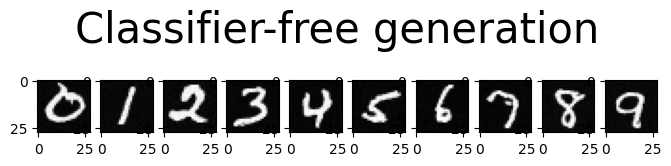

In [48]:
print("Generating new images")

generated = generate_new_images_cfg(
        best_model,
        n_classes=n_classes,
        device=device,
        gif_name="mnist_cfg.gif"
    )
print(generated.shape)
show_images_cfg(generated, n_classes, "Classifier-free generation")

Number of images: 10


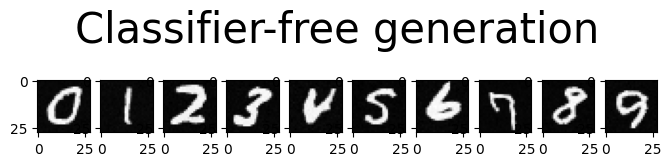

In [49]:
generated = generate_new_images_cfg(
        best_model,
        n_classes=n_classes,
        device=device,
        gif_name="mnist_cfg.gif"
    )
show_images_cfg(generated, n_classes, "Classifier-free generation")

With $w = 1$, the noise toward the noise for the class has been emphasized. Image quality should become better with the sacrifice of the diversity.

Number of images: 10


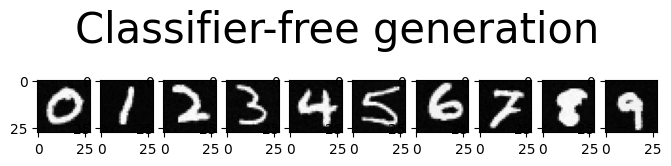

In [50]:
# w = 1.
generated = generate_new_images_cfg(
        best_model,
        n_classes=n_classes,
        device=device,
        gif_name="mnist_cfg.gif",
        w_val = 1.
    )
show_images_cfg(generated, n_classes, "Classifier-free generation")

Number of images: 10


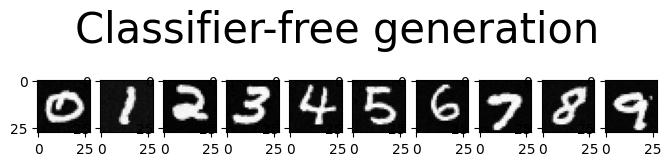

In [51]:
# w = 1.
generated = generate_new_images_cfg(
        best_model,
        n_classes=n_classes,
        device=device,
        gif_name="mnist_cfg.gif",
        w_val = 1.
    )
show_images_cfg(generated, n_classes, "Classifier-free generation")

How about when $w = 2$?

Number of images: 10


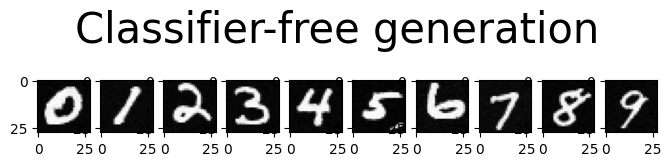

In [52]:
# w = 2.
generated = generate_new_images_cfg(
        best_model,
        n_classes=n_classes,
        device=device,
        gif_name="mnist_cfg.gif",
        w_val = 2.
    )
show_images_cfg(generated, n_classes, "Classifier-free generation")

Number of images: 10


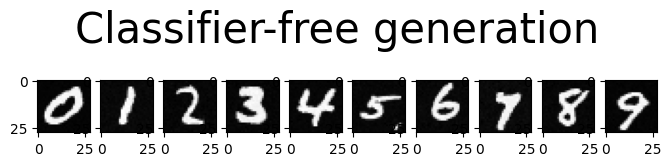

In [53]:
# w = 2.
generated = generate_new_images_cfg(
        best_model,
        n_classes=n_classes,
        device=device,
        gif_name="mnist_cfg.gif",
        w_val = 2.
    )
show_images_cfg(generated, n_classes, "Classifier-free generation")

When $w$ is negative, the guidance is weak, 

Number of images: 10


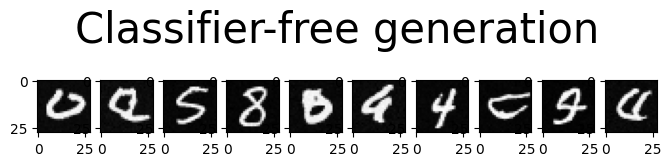

In [54]:
# w = -1.
generated = generate_new_images_cfg(
        best_model,
        n_classes=n_classes,
        device=device,
        gif_name="mnist_cfg.gif",
        w_val = -1.
    )
show_images_cfg(generated, n_classes, "Classifier-free generation")

Number of images: 10


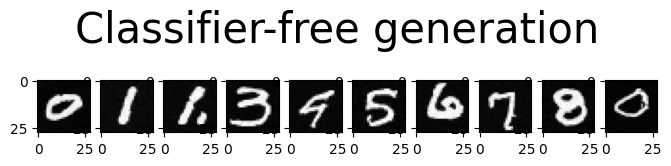

In [55]:
# w = -0.2
generated = generate_new_images_cfg(
        best_model,
        n_classes=n_classes,
        device=device,
        gif_name="mnist_cfg.gif",
        w_val = -0.2
    )
show_images_cfg(generated, n_classes, "Classifier-free generation")